# <font color='blue'><center><u>__Using Pipelines to Identify an Optimal Model in the Classification of the Daily Direction of USDCAD__</center><u></font>

<font color='blue'><br> __Joe Guirguis__</br></font>
<font color='blue'> __Date: May 2022__</font>

## <font color='blue'> __Abstract__ </font>

Identifying the optimal model for a machine learning problem requires many steps.  Not only is one faced with the choice between several potential classes of models but also one is faced with choosing between several different versions of a model (i.e. hyper-parameter tuning) which can be costly in terms of time to execute. The process is complicated a bit for models relying on time-series data since the conventional methods of validation (i.e. cross-validation) do not maintain the temporal order of the data.  In this analysis, we demonstrate an efficient and cost-effective framework for model selection that addresses these issues.  We will use the scikit-learn Pipeline Class to parsimonously train, validate and test several models with the aim of building a trading strategy to predict the direction of USDCAD.  The trading strategy will take a long unit position if the model predicts an upwards directional price movement and a short unit position if the model predicts a downwards directional price movement.  To aid the models we will transform the features so that they are stationary.  Stationary data possess beneficial mean-reverting properties which can make it easier for models to ingest.  To overcome the problems of cross-validation, we will rely upon time-series cross-validation. We will begin by looking at Logistic Regression which is one of the simpler binary classifiers and compare it against more complex models such as Support Vector Machines (SVMs) and Multi-Layer Perceptrons (MLPs).  Finally we examine whether an ensemble model, Gradient Boosting Classifier (GBC), which combines multiple decision trees to create a more powerful model, can outperform the simpler models.  

## <font color='blue'> __Imports__ </font> 

We will rely primarily on numpy and pandas data structures to hold and manipulate the data.  The adfuller method will be used to test whether features are stationary.

In [1]:
#Import packages for data analysis and statistics
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

For visualization, we will import matplotlib, seaborn and itertools.  Itertools will be used to create a cartesian product to facilitate dynamic chart creation.

In [2]:
#import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools

import seaborn as sns
sns.set_theme()

For model construction and implementation, we will rely on from various subpackages of `scikit-learn`.  These will be used to for building the various models and will be explained in more detail when encountered.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

Finally, we import additional modules from `scikit-learn` that will aid us with constructing pipelines and evaluating models.  `make_pipeline` constructs a pipeline from given estimators.  `GridSearchCV` performs an exhaustive search over specified parameter values for a given model. `train_test_split` splits data into train and test sets.  `TimeSeriesSplit` will be used as an argument in `GridSearchCV` to ensure that the temporal order of the data is maintained when executing cross-validation.  `accuracy_score` is a helper method to compute the percentage of total correct predictions.  `confusion_matrix` is a method that computes the accuracy for each classification. `ConfusionMatrixDisplay` is used to produce confusion matrix visualizations.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## <font color='blue'> __Raw Data__ </font> 

Interest rate differentials are typically highly correlated with foreign exchange rates so we will look at Canadian and U.S. interest rates.  In addition, we think changes in stock market values may also be positively related to exchange rates since capital tends to flow in the direction where it can find the highest return.  Finally, we also retrieve data for the VIX as we suspect that heightened market volatility leads to demand for safe haven assets such as U.S. Treasury Rates and the USD.

##### We will retrieve daily data from several sources:
 - Bank of Canada (https://www.bankofcanada.ca/rates/interest-rates/bond-yield-curves/)
     - Canada interest rates
 - Federal Reserve Economic Data - St. Louis Fed (https://fred.stlouisfed.org/categories/115)
     - U.S. interest rates
 - Yahoo Finance (API)
     - U.S. Stock Market Prices - S&P 500
     - Canada Stock Market Prices - S&P/TSX Composite index
     - U.S. Volatility Levels - VIX
     - USD CAD Exchange Rate - USDCAD

##### Below are the pre-processing details for each data set

### <font color='blue'> __Canada Interest Rates__ </font> 

Bank of Canada provides several different types of interest rate data.  We will work with the data set titled _yield curves for zero coupon bonds_ since it contains both short and long-term maturities.  This data contains 120 points on the yield curve between 0.25 years to 30-years separated by 0.25 year increments but we will only be using a few points on the curve. 

In order to import the data in a fashion that is more easily usable, we set the following parameters in the _read_csv_ method.  Following each parameter we explain the artifacts in the data that gave rise to the setting:

 - _skipinitialspace_: column names along with the values contain a leading whitespace.  By setting this parameter to True, we are removing the leading white space.
 - _na_values_: some of the values are set to 'na' which is not contained in the list of default values that are considered NaNs.  Fortunately, this parameter allows us to instruct the read_csv method to treat 'na' as NaN.
 - _usecols_: the data set contains 120 columns of data along with one empty column.  Using a list comprehension, we exclude the empty column.
 - _index_col_: the first column contains dates so we set this as our index.
 - _parse_dates_: by default, date columns are represented as _object_ when loading data from a CSV file.  By setting to True we can process the dates as _DatetimeIndex_.

In [5]:
raw_canada = pd.read_csv('cad_yield_curves.csv', skipinitialspace = True, na_values = 'na', usecols =[i for i in range(121)], parse_dates=True, index_col=0).dropna()

Using the _info()_ method we see that we confirm that we've imported 120 columns of numerical data spanning between 1991 and Q1 2022.

In [6]:
raw_canada.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7728 entries, 1991-01-02 to 2022-03-30
Columns: 120 entries, ZC025YR to ZC3000YR
dtypes: float64(120)
memory usage: 7.1 MB


We are only interested in the 3M, 6M, 1Y and 10Y points on the yield curve so our next step is to subset the data and retrieve the columns of interest.

In [7]:
data_canada = raw_canada[['ZC025YR', 'ZC050YR', 'ZC100YR', 'ZC1000YR']]

As we'll see below the USDCAD data is only available beginning Q32003 so we'll also subset the data by date.

In [8]:
data_canada = data_canada.loc['2003-09-30':'2022-03-31']

Next we explore the evolution of these four points of the yield curve by visualizing them.  To do so we create a function that will we will reuse throughout this notebook.  The function takes the following arguments:

- _data_: time series data organized as a data frame with each separate series stored in a column and dates are stored in the index.

- _title_: title of the figure

- _dim_: number of subplot rows and columns.  For purposes of this paper we only consider square dimensions. Default is a subplot with 2 rows and 2 columns.

- _yr_: number of years to separate the x-axis ticks.

- _percent_: boolean that determines whether data y-axis should be represented as a %

- _share_ax_: boolean that specifies whether subplots should share y-axis.

In [9]:
def plot_data(data, title, dim=2, yr=6, percent=True, share_ax = True):
    # create a 2 x 2 subplot (unless otherwise specified). if sharey is True, the subplots share the y-axis.  
    # this may be desireable for formatting purposes.
    # note the subplots always share the x-axis. this is desireable for formatting purposes.
    if share_ax:
        fig, axs = plt.subplots(nrows=dim, ncols=dim, sharex='col', sharey='row');
    else:
        fig, axs = plt.subplots(nrows=dim, ncols=dim, sharex='col')
        
    # controls the amount of height reserved for space between subplots
    plt.subplots_adjust(hspace=0.5)
    # figure title
    fig.suptitle(title)

    # cartesian product of the subplot dimensions along with an index 
    # to facilitate dynamic chart creation. the star operator is used
    # to unpack the list comprehension.
    for idx, tup in enumerate(itertools.product(*[range(s) for s in axs.shape])):
        # set the position of the subplot
        ax = axs[tup[0], tup[1]]
        # if percent is True set the ylabel to be a % sign
        if percent:
            ax.plot(data.index, data.iloc[:,idx] * 100)
            fig.text(0.04, 0.5, '%', va='center', rotation='vertical')
            #ax.set_ylabel('%')
        else:
            ax.plot(data.index, data.iloc[:,idx])
        # set the axis title
        ax.set_title(data.columns[idx].lower())
        # set the spacing for the x-axis labels only for the last row
        if idx >= dim:
            ax.xaxis.set_major_locator(mdates.YearLocator(yr))
            
            
#This is used to center the plots            
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")            
        

The charts show that the general long-term trend of interest rates has been lower. Trending data is typically non-stationary.  Stationary data exhibit a constant mean and variance and is typically a desireable characteristic in features when making predictions.  If a series is stationary, we might have greater confidence that the data will revert back to the mean following sharp deviations. 

We will engage in the below series of steps to transform the data which will be repeated on other data sets:

 1. Visualize the data
 2. Test for stationarity
 3. Transform non-stationary data
 4. Visualize transformed data
 5. Retest transformed data

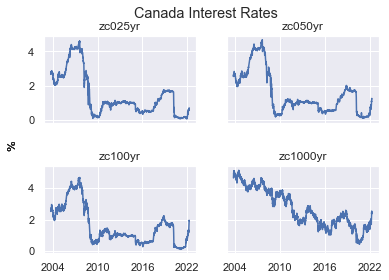

In [10]:
plot_data(data_canada, 'Canada Interest Rates')

To test for stationarity, we can run a statistical test, the Augmented Dickey Fullter (ADF) test, which allows us to quantitatively assess our observations. Similar to other statistical tests, the ADF null hypothesis proposes that there is no difference between the series of interest and other data series (most data series are non-stationary).  In other words, the null hypothesis is that the data is not stationary. To reject the null hypthesis and show that a series is stationary, we need the p-value produced by the test to be lower than the level of significance.  We will use a significance level of 0.05 which is standard.  Since we will need to check for stationarity in other data sets we will create a function that outputs the p-value, t-stat amd critical value for each time series.

In [11]:
def adf(data):
    # loop over the columns in the data frame
    for i, col in enumerate(data.columns):
        # store the results of the test and print.  we are concerned with only three values, the others are stored as _
        t_stat, p_value, _, _, critical_values, _  = adfuller(data.iloc[:,i])
        print(f'{col:>20} | p value: {p_value:.3f} | t-stat: {t_stat:.3f} | critical value: {critical_values["5%"]:.3f}')           

Since each of the p-values is greater than 0.05, we fail to reject the null hypothesis and therefore confirm that each series is not stationary.  t-stats that are greater than the critical value also suggest that the data is not stationary.  This leads us to conclude that we will need to transform the data in order to produce a stationary series.

In [12]:
adf(data_canada)

             ZC025YR | p value: 0.608 | t-stat: -1.347 | critical value: -2.862
             ZC050YR | p value: 0.590 | t-stat: -1.383 | critical value: -2.862
             ZC100YR | p value: 0.599 | t-stat: -1.365 | critical value: -2.862
            ZC1000YR | p value: 0.392 | t-stat: -1.776 | critical value: -2.862


One common way to transform a non-stationary series to a stationary series is by taking the log difference of the series.  Before doing so, however, we should check whether any series contain 0 values since the log of 0 is undefined.

In [13]:
def zero_check(data):
    # loop over all the columns, check if any contain 0, print results
    for col in data.columns:
        num_zeros = len(data[data[col] == 0])
        print(f'{col:>20} | # zero values: {num_zeros}') 

In [14]:
zero_check(data_canada)

             ZC025YR | # zero values: 0
             ZC050YR | # zero values: 0
             ZC100YR | # zero values: 0
            ZC1000YR | # zero values: 0


Since there are no zero values, we can safely take the log difference and store the difference in a new data frame. After taking the log-difference of each series we see that the data looks like it is has been de-trended.  Although the variance is charecterized by a few sharp moves especially in the 1 yr data, the mean appears to be constant around 0. 

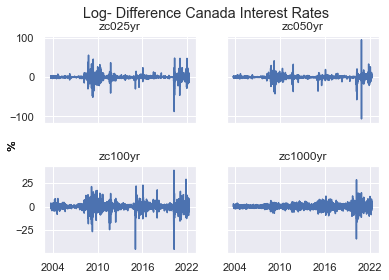

In [15]:
data_canada1 = np.log(data_canada).diff().dropna()
plot_data(data_canada1, 'Log- Difference Canada Interest Rates')

Below are the results of the ADF test after taking the transformation. Since the p-values are below the 0.05 level, we can reject the null hypothesis that each series is non-stationary.  We also note that the t-stats are much smaller than the critical values as well

In [16]:
adf(data_canada1)

             ZC025YR | p value: 0.000 | t-stat: -14.617 | critical value: -2.862
             ZC050YR | p value: 0.000 | t-stat: -13.629 | critical value: -2.862
             ZC100YR | p value: 0.000 | t-stat: -16.299 | critical value: -2.862
            ZC1000YR | p value: 0.000 | t-stat: -15.147 | critical value: -2.862


### <font color='blue'> __U.S. Interest Rates__ </font> 

FRED provides interest rate data across the entire yield curve.  Unlike the BOC which provides data for each point on the yield curve in one csv file, FRED provides data for each point on the yield curve in a separate file.  Therefore, we retrieved data for 3M, 6M 1Y and 10Y points on the constant maturity yield curve and then combined them into one csv titled _us_rates.csv_ for import. Unlike the Canadian data, the U.S. rate data required minimal pre-processing.

In [17]:
raw_usa = pd.read_csv('us_rates.csv', index_col=0, parse_dates=True).dropna()

Using the _info()_ method we see that we've imported 4 columns of numerical data spanning between 1981 and early April 2022

In [18]:
raw_usa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10152 entries, 1981-09-01 to 2022-04-08
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FRED/DGS3MO - Value  10152 non-null  float64
 1   FRED/DGS6MO - Value  10152 non-null  float64
 2   FRED/DGS1 - Value    10152 non-null  float64
 3   FRED/DGS10 - Value   10152 non-null  float64
dtypes: float64(4)
memory usage: 396.6 KB


Similar to what we did the BOC interest rate data, we subset the U.S. interest rate data between Q303 and Q122.

In [19]:
data_usa = raw_usa.loc['2003-09-30':'2022-03-31']
data_usa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4630 entries, 2003-09-30 to 2022-03-31
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FRED/DGS3MO - Value  4630 non-null   float64
 1   FRED/DGS6MO - Value  4630 non-null   float64
 2   FRED/DGS1 - Value    4630 non-null   float64
 3   FRED/DGS10 - Value   4630 non-null   float64
dtypes: float64(4)
memory usage: 180.9 KB


Similar to the Bank of Canada data, we see that the general trend of interest rates has been lower.  The data appear to be non-stationary.

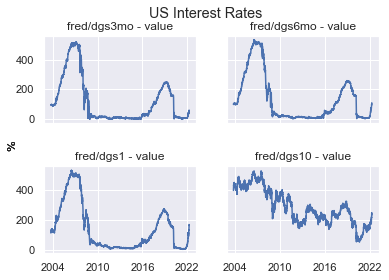

In [20]:
plot_data(data_usa, 'US Interest Rates')

The results of the dickey fuller test suggest that we can't reject the null hypothesis since the p-values are above 0.05.

In [21]:
adf(data_usa)

 FRED/DGS3MO - Value | p value: 0.695 | t-stat: -1.149 | critical value: -2.862
 FRED/DGS6MO - Value | p value: 0.692 | t-stat: -1.157 | critical value: -2.862
   FRED/DGS1 - Value | p value: 0.681 | t-stat: -1.182 | critical value: -2.862
  FRED/DGS10 - Value | p value: 0.448 | t-stat: -1.667 | critical value: -2.862


Before taking the log-difference we check for zero values.

In [22]:
zero_check(data_usa)

 FRED/DGS3MO - Value | # zero values: 21
 FRED/DGS6MO - Value | # zero values: 0
   FRED/DGS1 - Value | # zero values: 0
  FRED/DGS10 - Value | # zero values: 0


We remove the zero values and then take the log-difference of the data and observe that each series has now been transformed to a stationary series.

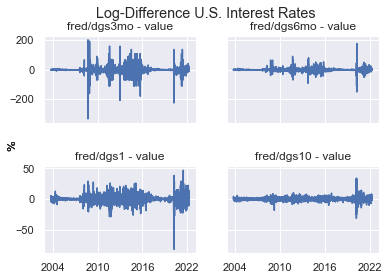

In [23]:
data_usa = data_usa[data_usa[data_usa.columns[0]] != 0]
data_usa1 = np.log(data_usa).diff().dropna()
plot_data(data_usa1, 'Log-Difference U.S. Interest Rates')

Again, although the variance appears to fluctuate in some areas of each series, we don't think this will significantly to affect the stationarity.  Moreover, the mean appears constant near 0.  


In [24]:
adf(data_usa1)

 FRED/DGS3MO - Value | p value: 0.000 | t-stat: -15.251 | critical value: -2.862
 FRED/DGS6MO - Value | p value: 0.000 | t-stat: -15.614 | critical value: -2.862
   FRED/DGS1 - Value | p value: 0.000 | t-stat: -9.924 | critical value: -2.862
  FRED/DGS10 - Value | p value: 0.000 | t-stat: -10.768 | critical value: -2.862


Our observations are confirmed with the results of the augmented dickey fuller test.  We see that the p-values are all lower than 0.05 coupled with very small t-stats.

### <font color='blue'> __Yahoo Finance Data__ </font> 

Yahoo Finance provides OHLCV data for U.S. stock tickers, U.S. and non-U.S. stock indices, FX rates along with other security prices.  In addition to retrieving the USDCAD FX rate which is our target variable, we also retrieve data for the S&P 500, S&P/TSE Composite and the VIX.  

In times of stress, investors typically look for safe haven assets such as high quality government securities.  As such, we include the S&P 500, S&P/TSE Composite and VIX series as possible features due to the belief that there may be an indirect link between equity and volatility markets and the USDCAD exchange rate.  In other words, when there are sharp sell-offs in the equity markets, investors typically reallocate funds to government debt which pushes rates lower (pari-passu) and subsequently may impact interest rate differentials.

We import the csv named `yfinance.csv` using the `read_csv` method. The data originated from the `yfinance` api which we then exported to `csv`.

In [25]:
# The raw data contains multi-index columns so we account for this by utilizing the header parameter.
raw_yf = pd.read_csv('yfinance.csv', header=[0,1], index_col=0, parse_dates=True)

Using the _info()_ method we see that we've imported 23 columns of numerical data spanning between Q3 2003 and Q1 2022.

In [26]:
raw_yf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4575 entries, 2003-09-17 to 2022-04-27
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (USDCAD=X, Open)       4575 non-null   float64
 1   (USDCAD=X, High)       4575 non-null   float64
 2   (USDCAD=X, Low)        4575 non-null   float64
 3   (USDCAD=X, Close)      4575 non-null   float64
 4   (USDCAD=X, Adj Close)  4575 non-null   float64
 5   (USDCAD=X, Volume)     4575 non-null   float64
 6   (^VIX, Open)           4575 non-null   float64
 7   (^VIX, High)           4575 non-null   float64
 8   (^VIX, Low)            4575 non-null   float64
 9   (^VIX, Close)          4575 non-null   float64
 10  (^VIX, Adj Close)      4575 non-null   float64
 11  (^VIX, Volume)         4575 non-null   float64
 12  (^GSPTSE, Open)        4575 non-null   float64
 13  (^GSPTSE, High)        4575 non-null   float64
 14  (^GSPTSE, Low)         4575 non-null  

Since we only need the closing prices (Adjusted Close), we extract those columns and discard the rest.

In [27]:
# list comprehension which operates on multi-index columns to extract the adjust close for each ticker
data_yf = [raw_yf[c]['Adj Close'] for c  in raw_yf.columns.levels[0]]
# concatenates the elements of a list back to a data frame.
data_yf = pd.concat(data_yf, axis=1)
# renames the columns 
data_yf.columns = ['USDCAD','SPX', 'TSE', 'VIX']

In [28]:
data_yf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4575 entries, 2003-09-17 to 2022-04-27
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USDCAD  4575 non-null   float64
 1   SPX     4575 non-null   float64
 2   TSE     4575 non-null   float64
 3   VIX     4575 non-null   float64
dtypes: float64(4)
memory usage: 178.7 KB


As we did with the interest rate series, we inspect the data graphically. The first three series appear to be trending upward while the VIX appears to have no trend.  We look to the ADF test for confirmation related to the non-stationarity of the data.

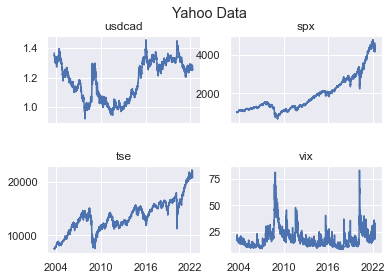

In [29]:
plot_data(data_yf, 'Yahoo Data', share_ax=False, yr=6, percent=False)

In [30]:
adf(data_yf)

              USDCAD | p value: 0.306 | t-stat: -1.956 | critical value: -2.862
                 SPX | p value: 0.997 | t-stat: 1.344 | critical value: -2.862
                 TSE | p value: 0.732 | t-stat: -1.056 | critical value: -2.862
                 VIX | p value: 0.000 | t-stat: -5.184 | critical value: -2.862


The adf confirms our intuition that the first three series are non-stationary.  Even though the VIX data appears to be stationary we decide to also take its log difference so that it is on a similar scale as the other features.  But before doing so, we check for zero values and see that no adjustments are necessary.

In [31]:
zero_check(data_yf)

              USDCAD | # zero values: 0
                 SPX | # zero values: 0
                 TSE | # zero values: 0
                 VIX | # zero values: 0


We see that the log-difference transformation looks to have made the data stationary.

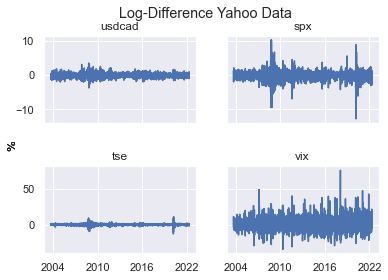

In [32]:
data_yf1 = np.log(data_yf).diff().dropna()
plot_data(data_yf1, 'Log-Difference Yahoo Data')

We confirm this by running the adf test and find that our observations are confirmed.

In [33]:
adf(data_yf1)

              USDCAD | p value: 0.000 | t-stat: -31.219 | critical value: -2.862
                 SPX | p value: 0.000 | t-stat: -15.799 | critical value: -2.862
                 TSE | p value: 0.000 | t-stat: -12.826 | critical value: -2.862
                 VIX | p value: 0.000 | t-stat: -28.623 | critical value: -2.862


### <font color='blue'> __Data Consolidation, Feature Engineering and Train/Test Splitting__ </font> 

We have completed the data cleaning phase and are now in a position to conduct a few more tasks to prepare the data to be ingested by the machine learning models.  The first step is to merge the three intermediate data frames: `data_canada1`, `data_usa1`,`data_yf1` into one master data frame which we'll name `data`. Following the merge, we obtain one dataframe containing 12 series between Q3 2003 and Q1 2022

In [34]:
#merge canada/us interest rate data
data = pd.merge(data_canada1, data_usa1, left_index=True, right_index=True)
#merge interest rate data with yahoo data
data = pd.merge(data, data_yf1, left_index=True, right_index=True)

Following the merge, we obtain one dataframe containing 12 series between Q3 2003 and Q1 2022

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4488 entries, 2003-10-01 to 2022-03-30
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ZC025YR              4488 non-null   float64
 1   ZC050YR              4488 non-null   float64
 2   ZC100YR              4488 non-null   float64
 3   ZC1000YR             4488 non-null   float64
 4   FRED/DGS3MO - Value  4488 non-null   float64
 5   FRED/DGS6MO - Value  4488 non-null   float64
 6   FRED/DGS1 - Value    4488 non-null   float64
 7   FRED/DGS10 - Value   4488 non-null   float64
 8   USDCAD               4488 non-null   float64
 9   SPX                  4488 non-null   float64
 10  TSE                  4488 non-null   float64
 11  VIX                  4488 non-null   float64
dtypes: float64(12)
memory usage: 455.8 KB


Next we reorder the columns such that USDCAD is the last column in the dataframe. We also add one more series which will serve as our target variable.  The direction `d` takes a value of 1 when the log return > 0 and 0 otherwise.

In [36]:
#list compreshension to move target variable to end of data frame
data = data[[c for c in data if c not in ['USDCAD']] + ['USDCAD']]

In [37]:
data['d'] = np.where(data['USDCAD'] > 0, 1, 0)

The penulimate step in our data processing is to create lagged features for each of the 12 features.  This is implemented via the `create_lags` function.  We select a value of 5 for the lags so that there will be 60 features total.

In [38]:
def create_lags(df, feat, lags=5, target=['d']):
    # work with a copy of the dataframe to avoid any set value warnings
    df = df.copy()
    # Empty list to store empty column names
    cols = []
    
    for f in feat:
        for lag in range(1, lags + 1):
            # we don't want to lag the target variable
            if f not in target:
                # Create the name of the new column
                col = f'{f}_lag_{lag}'
                df[col] = df[f].shift(lag)
                cols.append(col)
    df.dropna(inplace=True)
    # return the column names and the data frame
    return cols, df

In [39]:
cols, data2 = create_lags(data, feat=data.columns)

The final step of our data preparation is to split the data into training and test data.  While this task can be easily implemented with a few lines of simple code, we instead write our own function which relies on the `scikit-learn` method __train_test_split__.  

The __train_test_split__ method takes takes `arrays` as the first two arguments representing the features and target variable separately.  Since a `DataFrame` is an analog of a two-dimensional array with both flexible row indices and column names we can pass our `data` `DataFrame` to the method along with our target variable `d` as a separate series.  We also set the parameters `train_size=0.8` so that 80% of the data will be training data and 20% will be used for testing. `shuffle=False` is set so that the temporal order of the data is maintained.

Note that we don't split the training data set again to create a separate validation set which is why we name the variables `X_trainval` and `y_trainval` rather than `X_train` and `y_train` .  We will rely on some built-in scikit-learn functionality to do this for us later.  This will be explained in the forthcoming sections.  

In [40]:
def prepare_data(data, trgt='d'):
    # features and target are to be passed in separately so we separate them
    target = data[trgt]
    features = data[[c for c in data.columns if c not in [trgt]]]
    X_trainval, X_test, y_trainval, y_test = train_test_split(data, target , train_size=0.8, shuffle=False)
    
    return X_trainval, X_test, y_trainval,  y_test

In [41]:
X_trainval, X_test, y_trainval, y_test = prepare_data(data2)

## <font color='blue'> __Machine Learning Models__ </font>

### <font color='blue'> __Pipeline Class__ </font>


Before we begin a discussion related to the models, it's important to discuss `scikit-learn's` `Pipeline` Class which we will use to train and validate each machine learning model that we select for this paper.  

Recall that the conventional way to evaluate supervised learning models is as follows:

1. Split the data into two sets: training and test
2. Choose a value for a given model argument (hyperparameter)
3. Split the training data into n folds for cross-validation
4. Train the model with the chosen hyperparameter value on n-1 folds 
5. Evaluate the model on the nth fold or validation set
6. Record the performance
7. Repeat steps 2-6 so that each fold has an opportunity to be the validation set
8. Repeat step 7 for each potential hyperparameter value
9. Choose the model with a given hyperparameter that produced the best performance
10. Retrain the model with the chosen hyperparameter on the entire training set (including validation set)
11. Evaluate the model on the test set

The cost of executing this process can be very high depending on how many times step 7 and 8 are executed and how complex the model is.  For instance, if there are 2 hyperparameters that require tuning and 5 values of interest to test and 5 cross-validation folds, then the model will need to be executed 125 times. If there are multiple models under consideration then the number of model runs is even higher.

To simplify this process, `scikit-learn` has a method called `GridSearchCV` which optimizes this process. Instead of using a nested `for loop` to fit the model 125 times, `GridSearchCV` only requires one call to the model.  Under the hood, `GridSearchCV` performs steps 2-10 with one simple call and also selects the parameter values with the best out-of-sample performance.  Needless to say, the cost savings are tremendous.

The `GridSearchCV` method when called is instantiated with the desired parameters.  The `fit` method then performs the cross-validation and select the hyperparameters with the best performance.


In addition to `GridSearchCV`, we will rely upon some additional scikit-learn tools .
 - __make_pipeline:__ this is a function that allows us to chain together machine learning steps.  Usually there are multiple steps that we might be interested in chaining together such as feature normalization, the output of which would be the input to a model.  Since we previously took care of feature engineering, our `make_pipeline` function will only contain a model.
 
 - __TimeSeriesSplit:__ this is a function that performs the splitting of the training data into successive training and validation sets.  Since traditional cross validation does not maintain the temporal order of the data, `TimeSeriesSplit` corrects for this.  Rather than splitting the data into mutually exclusive folds and rotating each fold as the validation set,  `TimeSeriesSplit`, in each split, returns the first n folds as a training set and the (n+1)th fold as the validationt set. Therefore, unlike standard cross-validation splits, successive training sets are supersets of those that come before them.
 
 - __GridSearchCV:__ this is the main function that performs the hyperparameter tuning.  In addition to taking the `pipe` as an argument, it also takes a `param_grid` which is a dictionary consisting of the parameters to tune as keys and the values as the dictionary value.  The syntax to define a `param_grid` is to specifify the model name followed by a double underscore followed by the parameter name (i.e. _model_name__parameter_name_). `cv` is the third argument and represents the type of cross validation that will be used. As mentioned above, we will be using `TimeSeriesSplit`.  Finally, the n_jobs argument is set to -1 so that all CPU's available are used. 
 
 - __fit:__ once the parameters are chosen they are used to fit the model over the entire training data set.

In [42]:
def build_model(model, param_grid):
    pipe = make_pipeline(model)
    tscv = TimeSeriesSplit(n_splits = 5)
    grid = GridSearchCV(pipe, param_grid = param_grid, cv = tscv, n_jobs = -1, refit=True)
    grid.fit(X_trainval[cols], y_trainval);
    return grid

### <font color='blue'> __Helper Functions__ </font>

Here we create several helper functions that we will apply when evaluating and testing each of the models below.

`compute_stats` is designed to evaulate each model with the hyper-parameters that are selected from `GridSeachCV`. Its input consists of the following:
 - `X_test`: Dataframe that includes feature and non-feature columns
 - `cols`: List of features
 - `grid`: Grid object that represents the fitted model with the optimal hyperparameters from cross-validation
 - `df`: DataFrame that is passed so that current model results are appended to previous model results.  A DataFrame is passed for all models except the first. 

Its output consists of two `DataFrames`:
 - `df2`: DataFrame containing the model stats
 - `test_temp`: DataFrame that appends the input DataFrame with model predictions and performance

In [43]:
def compute_stats(X_test, cols, grid, df=None):
    # make a copy to avoid warnings
    test_temp = X_test.copy()
    # predict the USDCAD direction with fitted model
    test_temp['p'] = grid.predict(test_temp[cols])
    # reset values to 1 and -1 to compute strategy returns
    test_temp['p'] = np.where(test_temp['p'] == 1, 1, -1)
    # compute strategy returns
    test_temp['s'] = test_temp['USDCAD'] * test_temp['p']
    # compute cumulative strategy and buy-and-hold returns 
    perf = test_temp[['USDCAD','s']].sum().apply(np.exp)        

    # create empty dictionary to hold model stats
    d = {}
    # substring manipulation to capture and extract the model name
    d.update({'model': [list(grid.best_params_.keys())[0].split('__')[0]]})
    # record the best score during time series cross validation produced by the parameters of interest
    d.update({'best_tscv_score': [grid.best_score_.round(2)]})
    # record score on the training set using the chosen parameters
    d.update({'train_score': [grid.score(X_trainval[cols], y_trainval).round(2)]})
    # record score on the test set using the chosen parameters
    d.update({'test_score': [grid.score(X_test[cols], y_test).round(2)]})
    # record score of a naive model that simply predicts the same direction each time
    d.update({'naive_score': [(y_test.value_counts().head(1) / y_test.value_counts().sum()).values[0].round(2)]})
    # record strategy performance based on model predictions
    d.update({'strat_performance': [perf.values[1].round(2)]})
    # record buy and hold performance
    d.update({'bmark_performance': [perf.values[0].round(2)]})
    # create DataFrame for output
    if df is not None:
        df1 = pd.DataFrame.from_dict(d)
        df1.set_index('model', inplace=True)
        df2 = pd.concat([df, df1], axis=0)
    else:
        df2 = pd.DataFrame.from_dict(d)
        df2.set_index('model', inplace=True)

    return df2, test_temp

`plot_heat_map` is designed to produce a user-friendly output of the performance of each combination of parameters from `GridSearchCV`.  Its input is the `grid` produced by `GridSeachCV` and the output is a heatmap.

In [44]:
def plot_heat_map(grid):
    df = pd.DataFrame(grid.cv_results_)
    # extract columns of interest
    cols1 = [col for col in df if col.startswith('param_')] + ['mean_test_score']
    # create dataframe using columns of interest to subset
    df1 = df[cols1]
    # rename columns so they're more user friendly
    df1.columns = [c.split('__')[1] if '__' in c else c for c in cols1]
    
    # Produce 1D or 2D heatmap depending on the number of parameters
    if len(df1.columns) == 2:
        # create a pivot table which makes it easier for the `sns.heatmap` function to produce a user-friendly output
        pt = pd.pivot_table(df1, index=df1.columns[0],values=df1.columns[1])
        sns.heatmap(pt, cmap='Blues', annot=True, fmt='.2%')
    else:
        pt = pd.pivot_table(df1, values=df1.columns[2],columns=df1.columns[1], index=df1.columns[0])
        sns.heatmap(pt, cmap='Blues', annot=True, fmt='.2%')

`plot_conf_matrix` is designed to show the percentage of each class that is classified correctly.  As arguments, it takes:
 - `y_test`: DataFrame of predictions
 - `X_test`: DataFrame of features and intermediate series
 - `cols` : List of features
 - `grid` : Grid object that represents the fitted model with the optimal hyperparameters from cross-validation
 
The output is a 2x2 matrix with percentages of correct and incorrect values.

In [45]:
def plot_conf_matrix(y_test, X_test, cols, grid):
    sns.reset_orig()
    ConfusionMatrixDisplay.from_predictions(y_test, grid.predict(X_test[cols]), normalize='true', cmap='Blues')    

`plot_performance` is a time series plot of the model performance versus the simple buy and hold performance
 - `test_temp`: DataFrame containing performance produced by `compute_stats` function
 - `model`: String representing the model name to be used as chart title
 
The output is a time series line chart.

In [46]:
def plot_performance(test_temp, model):
    # set seaborn theme
    sns.set_theme()
    fig, ax = plt.subplots();
    # time series plot for buy and hold
    ax.plot(test_temp['USDCAD'].cumsum().apply(np.exp), '-b', label='USDCAD');
    # time series plot for strategy
    ax.plot(test_temp['s'].cumsum().apply(np.exp), '-r', label='Strat');
    # set title
    ax.set_title(model);
    # set axis by years for user-friendly formatting 
    ax.xaxis.set_major_locator(mdates.MonthLocator(12))
    # add performance annotations and legend
    ax.annotate(np.exp(test_temp['USDCAD'].sum()).round(4), (test_temp.index[-1], np.exp(test_temp['USDCAD'].cumsum()).mean()), xytext=(-80, 10), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'));
    ax.annotate(np.exp(test_temp['s'].sum()).round(4), (test_temp.index[-1], np.exp(test_temp['s'].cumsum())[-1].round(4)), xytext=(-80, -10), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'));
    ax.legend()

## <font color='blue'> Models</font>

### <font color='blue'> __Model #1 Logistic Regression__ </font>

Logistic regression predicts the probability of an outcome using a special function called a sigmoid function.  Since it has only one primary tuning parameter `C` and builds upon the familiar linear regression model, it is considered a relatively simple machine learning model.  Since the math is relatively tractable, we will derive the model in order to better understand it.  The starting point is a linear regression model.  Note that we use a simple linear regression model (i.e. one variable) for simplicity but it can easily be extended to multiple regression.

\begin{equation}
p = b_0 + b_1x
\end{equation}

Recall that we're interested in predicting a probability.  Since the RHS of the equation can hold values that exceed $(0,1)$, the LHS is adjusted so that a wider range of values can be captured.

\begin{equation}
\frac{p}{1-p} = b_0 + b_1x
\end{equation}

This ratio, the probability of an event occurring over the probability that it doesn't occur is called the _odds_.  While it captures positive values, it doesn't capture negative values.  This can be rectified by wrapping the LHS in a logarithm:

\begin{equation}
\log(\frac{p}{1-p}) = b_0 + b_1x
\end{equation}


Since we ultimately want to predict the probability $p$ that an event will occur, we want to  isolate $p$ on the RHS.  Letting $z = b_0 + b_1x$,  we can then manipulate the above to arrive at 

\begin{align}
p = \frac{e^{z}}{1 + e^{z}} = \frac{1}{1 + e^{-z}}\\
\end{align}


The above expression is the sigmoid function and is shaped like an S when plotted.
When $z$ is large and positive the sigmoid function is close to 0.  Conversely when it's large and negative the sigmoid function approaches 1.

This model produces a probability of a discrete outcome given a set of input variables. `C` is the only parameter and controls the amount of regularization.  The strength of regularization corresponds to how hard the model will try to fit the training set.  High values of `C` tend to correspond to higher weights on the coefficients while lower values of `C` correspond to weights that are close to 0.

Below we look at 5 different values of `C` and let `scitkit-learn` choose the best value of `C` based on the out-of-sample performance on the validation set.

In [47]:
#we set the max_iter parameter to 1000 to ensure convergence of the model
model = LogisticRegression(max_iter=1000)
#we search over 5 values in the log space of C.
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [48]:
#build the model
grid = build_model(model, param_grid)

The heat map shows that a large value of `C`, 100, produced the best results during cross-validation.  This implies that very little 
regularization was needed to produce a model that generalized well on the validation data


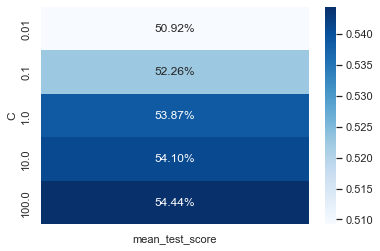

In [49]:
plot_heat_map(grid)

The confusion matrix shows that for both classes of data, gains and losses, accuracy on the test data was 60% or higher.  Specifically, the model predicted 69% of the declines and 60% of the gains in USDCAD accurately.

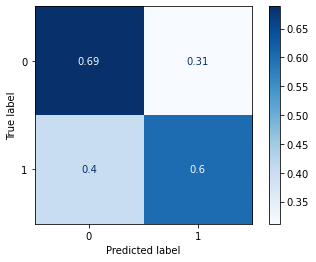

In [50]:
plot_conf_matrix(y_test, X_test, cols, grid)

In [51]:
# We compute the statistics (and store in results) from the cross-validation and add the model
# predictions to the test_data using the compute_stats function.
results, test_data = compute_stats(X_test, cols, grid)

The results dataframe produces additional insight.  Specifically we see that the best `tscv_validation` score was 54%.  This is an average over the five time series cross-validation splits using the parameter `C=100`.   

Once `C=100` was chosen, the model was fit over the entire training data set.  The `train_score` represents the percentage of model predictions on the training data using the fit model that were accurate.  

Impressively, the model accuracy on the test set was even better as evidenced by the `test_score` value of 65%.  Over the range of time between the end of 2018 and the beginning of 2022 we see that the model significantly outperformed a simple buy and hold strategy on USDCAD.  

It's also important to compare test `test_score`  against the `naive_score` of 51%.  The `naive_score` is the fraction of actual target values in the test set that were classified as gains.  We use this score as a benchmark and a common sense check as to whether our model can outperform a naive model that simply chose the most-likely outcome.

In [52]:
results

,best_tscv_score,train_score,test_score,naive_score,strat_performance,bmark_performance
model,,,,,,
logisticregression,0.54,0.61,0.65,0.51,3.19,0.97


Finally, we see that model significantly outperformed a simple buy and hold strategy of `USDCAD` over the test period.

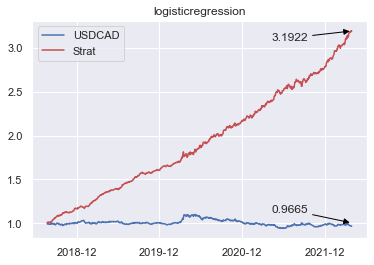

In [53]:
plot_performance(test_data,'logisticregression')

We store the results in a dictionary for later analysis

In [54]:
test_data_dict = {'LogReg': test_data}

### <font color='blue'> __Model #2 Support Vector Machines__ </font>

Support vector machines (SVMs) are based on the idea of finding a line or in higher dimensions a hyperplane that best divides a dataset into two classes.  In their simplest form, SVMs take data as an input and output a line (hyperplane) that separates those classes.  For some data, however, a line will not do a very good job.  We can see this in the below where it would be very difficult to separate the classes with a straight line.


In [55]:
from sklearn.datasets import make_blobs

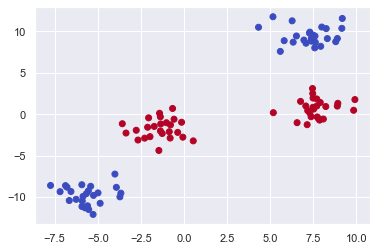

In [56]:
X, y  = make_blobs(centers=4, random_state=8)
y = y%2
plt.scatter(X[:,0], X[:, 1], c=y, cmap='coolwarm');

The way around this is to add new features by adding interactions of the features. By adding a third feature and increasing the dimensions of the feature space it is now possible to more easily separate the categories.

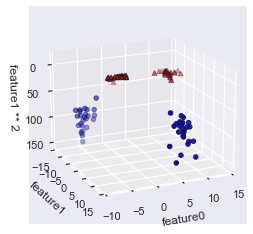

In [57]:
#add new feature that is the square of feature 1
X_new = np.hstack([X, X[:, 1:] ** 2])

figure = plt.figure()
# visualize in 3D
ax = plt.axes(projection='3d')
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='blue',
            cmap='coolwarm', edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='red', marker='^',
           cmap='coolwarm', edgecolor='k')
ax.set_xlim([-10, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-20, 160])
ax.view_init(-162, -66)
ax.set_xlabel("feature0");
ax.set_ylabel("feature1");
ax.set_zlabel("feature1 ** 2");


The challenge, however, is to determine which features to add without adding so many features that the computation becomes very expensive.  Fortunately during training, the SVM learns how important each of the data points in the training set are to determining the boundary between classes.  The points that are deemed important are called support vectors and are usually small in number relative to the whole data set.

Predictions for each class are determined by the distance of each point to the support vectors where typicaly shorter distances result in classification to the class of the support vector.  The distance between points is measured by the radial kernel:

\begin{equation}
\exp(-\gamma \lVert x_1 - x_2 \rVert^2)
\end{equation}

The radial kernel also determines how much influence each observation in the training dataset has.  The parameter `gamma` scales how far the influence of a single training example reaches with low values corresponding to a far reach and high values to a limited reach. 

Like logistic regression, there is also a parameter `C` which is a regularization parameter. Low values of `C` are associated with underfitting but better generalization. In other words, lower values of `C` will tolerate more misclassified points in order to produce a more generalized model _(Mueller and Guido Chapter 2)_.


In [58]:
from sklearn import svm

In [59]:
model = svm.SVC(max_iter=100000, kernel='rbf')

In [60]:
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
             'svc__gamma':[0.01, 0.1, 1, 10]}

In [61]:
grid = build_model(model, param_grid)

The heat map shows that a high value of `C`, 100, and a low value of `gamma`, 0.01, produced the best results during cross-validation.  While the high `C` value implies that there was little regularization needed in order to produce good results on the validation data.  The low gamma implies that each point had a far reach meaning that not only did close points influence the classification of new observations but so did far away points.

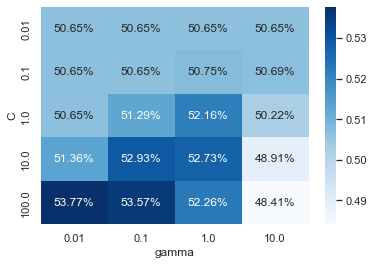

In [62]:
plot_heat_map(grid)

The confusion matrix shows that the model did a much better job predicting losses than gains.  77% of the losses were correctly predicted on the test data while only 43% of the gains were accurately predicted.

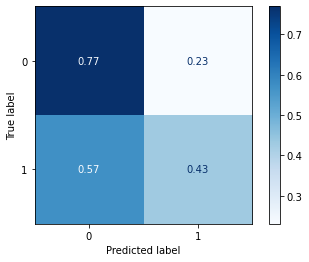

In [63]:
plot_conf_matrix(y_test, X_test, cols, grid)

In [64]:
results, test_data = compute_stats(X_test, cols, grid, df=results)

The below statistics reveal a similar pattern as observed with the `logistic regression` model.  That is, the model produced better out-of-sample results than in-sample and importantly outperformed the `naive_model`.

In [65]:
results

,best_tscv_score,train_score,test_score,naive_score,strat_performance,bmark_performance
model,,,,,,
logisticregression,0.54,0.61,0.65,0.51,3.19,0.97
svc,0.54,0.59,0.60,0.51,2.57,0.97


The SVM significantly outperformed the buy-and-hold benchmark while underperforming the logistic regression model.

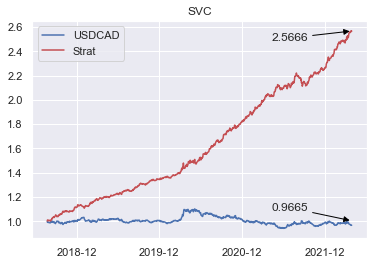

In [66]:
plot_performance(test_data, 'SVC')

We store the results in a dictionary for later analysis.

In [67]:
test_data_dict['SVC'] = test_data

### <font color='blue'> __Model #3 Multi Layer Perceptrons__ </font>


Multi-layer Perceptron (MLP) models are a type of neural network that can be viewed as generalizations of linear models.  In a traditional linear model (think linear regression) the set of weights or parameters are multiplied with the input data to produce the target value.


In [68]:
# pip install graphviz
# pip install imread
import mlp_graphs

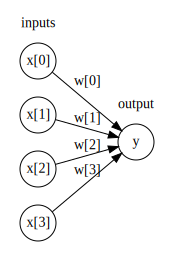

In [69]:
mlp_graphs.plot_regression_graph()

Unlike traditional linear models, however, `MLPs` can have intermediate layers between the inputs and the output.  These intermediate layers are called hidden layers and each hidden layer usually contains multiple nodes called hidden units.  As a result, there are typically many more parameters in an `MLP` relative to a traditional linear model.  Below is a simple graphic representing a neural network with two hidden layers each consisting of three hidden units.

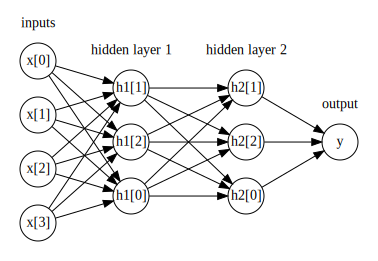

In [70]:
mlp_graphs.plot_hidden_layer_graph()

In addition to the hidden units and hidden layers, an `MLP` also consists of an activation function which is used to introduce non-linearity.  The most popular activation function is the rectified linear unit (`relu`) which is similar to a call option payoff diagram and takes the functional form `max(x, 0)`.  The activation function is applied to the output of each hidden unit. 


In [71]:
#instantiate the model with shuffle = False so temporal order of samples is maintained.
#max_iter is set to a relatively high number to allow the model to converge
#random_state is set to 0 to allow for replication of results.
model = MLPClassifier(shuffle=False, max_iter = 10000, random_state=0, activation = 'relu')

We will tune the hidden layers and units along with the alpha.  Each entry of the tuple specifies the number of hidden units in each layer.  `(16,)` , for example, implies one hidden layer with 16 hidden units while `(64, 64)` implies two hidden layers each containing 64 hidden units.

Alpha is a regularization parameter and can be tuned to combat both underfitting and overfitting.  Increasing alpha forces coefficients to move toward zero which could improve the model's ability to generalize on unseen data.  Converselg, decreasing alpha allows the coefficients to increase and could be used to combat underfitting.

In [72]:
param_grid = {'mlpclassifier__hidden_layer_sizes': [(16,), (16, 16), (64, 64), (128, 128)],
             'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1]}

In [73]:
grid = build_model(model, param_grid)

The heat map shows that an `alpha` of 0.001 and a single layer consisting of 16 hidden units produced the best results during cross-validation. 

The relatively modest value of `alpha` implies that there was little regularization needed in order to produce good results on the validation data. 

Similarly, a very simple neural network consisting of one layer with 16 hidden units produced the best results during cross-validation.

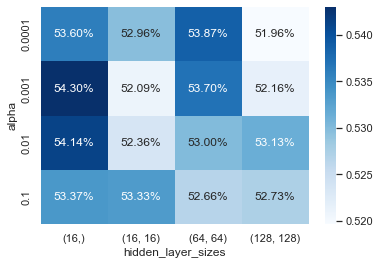

In [74]:
plot_heat_map(grid)

The confusion matrix shows that the model did a good job predicting both losses and gains reaching 60% accuracy on the test data for both classes.

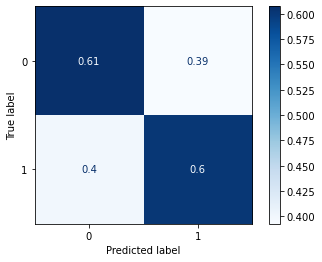

In [75]:
plot_conf_matrix(y_test, X_test, cols, grid)

In [76]:
results, test_data = compute_stats(X_test, cols, grid, df=results)

Unlike the results we saw in the previous models, the MLP Classifier did not produce better results on the test set relative to the training set.  In addition, the MLP Classifier underperformed both the logistic regression model and SVC.  Due to the fact that the model had a similar test_score as the SVC, we can infer that one of the reasons for the underperformance was that the MLP Classifier misclassified some of the days with outsized gains and losses.

In [77]:
results

,best_tscv_score,train_score,test_score,naive_score,strat_performance,bmark_performance
model,,,,,,
logisticregression,0.54,0.61,0.65,0.51,3.19,0.97
svc,0.54,0.59,0.60,0.51,2.57,0.97
mlpclassifier,0.54,0.66,0.60,0.51,2.43,0.97


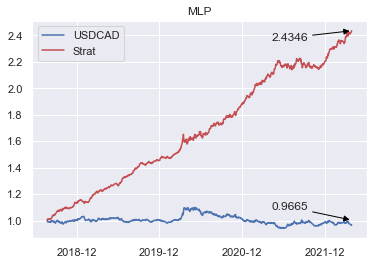

In [78]:
plot_performance(test_data, 'MLP')

We store the results in a dictionary for later analysis.

In [79]:
test_data_dict['MLP'] = test_data

### <font color='blue'>__Model #4 Gradient Boosting Classifier__ </font>


Gradient boosted classifiers are built upon decision trees so a discussion of decision trees is warranted. 
Decision trees are models that learn a hierarchy of if/else questions.  For example, in order to predict the direction of USDCAD a decision tree might determine that the most important question to ask would be whether the difference between the 1M treasury rate and the 1M canadian rate is positive for any given day.  Depending on the answer, the model would then ask another question until it reached the bottom of the tree and made a prediction of either up or down for USDCAD (see figure below).  

To construct a tree, the decision tree algorithm searches over all possible tests and finds the one that is most informative about the target variable.  It then splits the data and searches for the next most informative test continuing in this fashion until there is only one class in a given leaf (terminal node).  The tree that is selected is the one that gets to the true answer in the training set most quickly.

The main way that decision trees are controlled for overfitting is called pre-pruning which stops the creation of the tree early and essentially limits its depth.

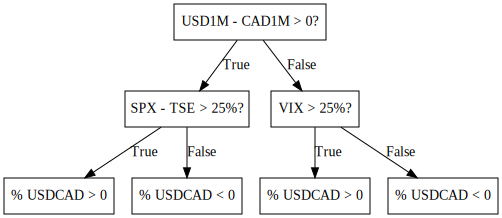

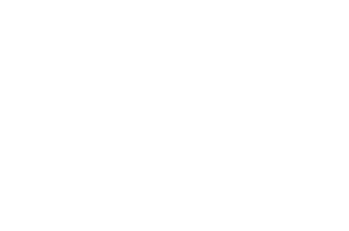

In [80]:
mlp_graphs.plot_tree()

Gradient boosted classifiers are an ensemble method.  An ensemble method combines multiple models.  Boosting is a type of ensemble method that tries to correct the errors of the previous model. In the case of gradient boosted classifiers, the algorithm combines many simple models.  The errors of a particular model in the series are addressed by the subsequent model in the series such that the new model tries to improve on the incorrect predictions of the previous model. This process is iteratively to improve performance.

The main way that gradient boosted classifiers are controlled for overfitting is via the `learning_rate` and the `n_estimators` parameters.  The latter refers to the number of trees to use while the former refers to how intensely each tree tries to correct the errors of the prior trees in the series. 

In [81]:
model = GradientBoostingClassifier(random_state=0, max_depth=3)

In [82]:
param_grid = {'gradientboostingclassifier__n_estimators': [1, 5, 25, 50, 100],
             'gradientboostingclassifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1]}

In [83]:
grid = build_model(model, param_grid)

The heat map shows that a `learning_rate` of 0.1 along with a `n_estimators` of 50 produced the best results during cross-validation. 

The selected `learning_rate` of 0.1 is relatively high but not so much so.  For instance, a `learning_rate` of 0.1 is the default setting used by the model.  Nonetheless, a value of 0.1 implies that each successive tree can make stronger corrections to the errors of the previous trees in the sequence.  While there is a risk of overfitting with a relatively higher learning rate, we also see the significant drop-off in accuracy at lower levels of the `learning_rate`.

The selected `n_estimators` of 50 means that 50 successive trees will be used and adds to the model's complexity.  It also means, however, that the model will have more chances to correct errors.

In short, we are mindful that the selected model is relatively complex and will be interested to see how the model generalizes on the test set.

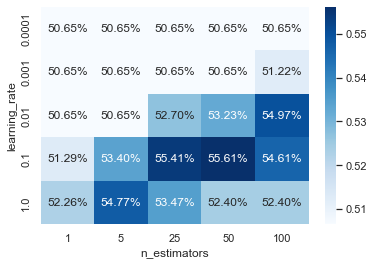

In [84]:
plot_heat_map(grid)

The results from the confusion matrix are encouraging in that the gradient boosted classifier predicted above 60% accuracy for each class of data on the test set.  This suggests that the model generalized well. The model's complexity paid dividends in the form of high prediction accuracy.

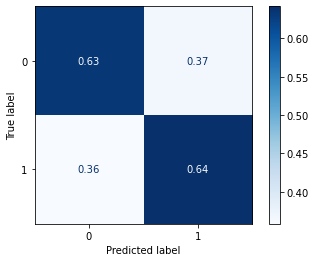

In [85]:
plot_conf_matrix(y_test, X_test, cols, grid)

In [86]:
results, test_data = compute_stats(X_test, cols, grid, df=results)

As we can see from comparing the `test_score` against the `train_score` there was a dropoff in the accuracy of approximately 8% (72% from 64%).  It's possible that the model's complexity could be improved upon but nonetheless the model significantly outperformed both the passive buy and hold benchmark along with the naive model.

In [87]:
results

,best_tscv_score,train_score,test_score,naive_score,strat_performance,bmark_performance
model,,,,,,
logisticregression,0.54,0.61,0.65,0.51,3.19,0.97
svc,0.54,0.59,0.60,0.51,2.57,0.97
mlpclassifier,0.54,0.66,0.60,0.51,2.43,0.97
gradientboostingclassifier,0.56,0.72,0.64,0.51,2.92,0.97


The cumulative strategy performance produced by the gradient boosting classifier at 292% was significantly better than the passive benchmark and was the second best of the four models.

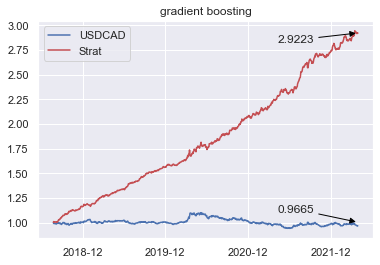

In [88]:
plot_performance(test_data, 'gradient boosting')

In [89]:
test_data_dict['GBC'] = test_data

### <font color='blue'> __Model Comparisons__ </font>


As we saw above, each of the four models outperformed the buy and hold benchmark.  This performance, however, was computed on a gross basis meaning transaction costs were not taken into account.  In this section we will adjust the performance by the number of trades and see whether each model was still able to outperform on a net basis.

The first step in doing so is to compute the number of trades undertaken by each model.  The range of the number of trades for all four models was between 400-450 trades which translated to roughly 1 trade for every two days on average.

#### <font color='blue'> __Turnover__ </font>


In [90]:
print(f'Strategy | # trades | % days w trade')
print('=' * 40)
for i in test_data_dict.keys():
    num = sum(test_data_dict[i]["p"].diff() != 0)
    tot = len(test_data_dict[i]) - 1
    per = num / tot
    print(f'{i:8} | {num:^8} | {per:8.2f}')

Strategy | # trades | % days w trade
LogReg   |   407    |     0.45
SVC      |   401    |     0.45
MLP      |   445    |     0.50
GBC      |   425    |     0.47


#### <font color='blue'> __Gross and Net Returns__ </font>


Next, we compute the impact that transaction costs had on each of the strategies.  Fortunately transaction costs for major FX pairs are relatively low.  According to Oanda, the cost to trade USD/CAD is 2.2 pips which translates to 0.022%.  The results remain quite encouraging with all four strategies outperforming the simple buy and hold strategy even after transaction costs are accounted for.

In [91]:
ptc = 0.00022
print(f'Strategy | Gross Return | Net Return')
print('=' * 40)
for i in test_data_dict.keys():
    test_data_dict[i]['net_return'] = np.where(test_data_dict[i]["p"].diff() != 0,
                                               test_data_dict[i]["s"] - ptc, test_data_dict[i]["s"])
    gr = np.exp(test_data_dict[i]["s"].sum()).round(2)
    nr = np.exp(test_data_dict[i]['net_return'].sum()).round(2)
    print(f'{i:8} | {gr:^12} | {nr:^12}')
    gr_usdcad = np.exp(test_data_dict[i]['s'].sum()).round(2)
    nr_usdcad = np.exp(test_data_dict[i]['USDCAD'].sum()).round(2)
print(f'USDCAD   | {nr_usdcad:^12} | {nr_usdcad:^12}')

Strategy | Gross Return | Net Return
LogReg   |     3.19     |     2.92    
SVC      |     2.57     |     2.35    
MLP      |     2.43     |     2.21    
GBC      |     2.92     |     2.66    
USDCAD   |     0.97     |     0.97    


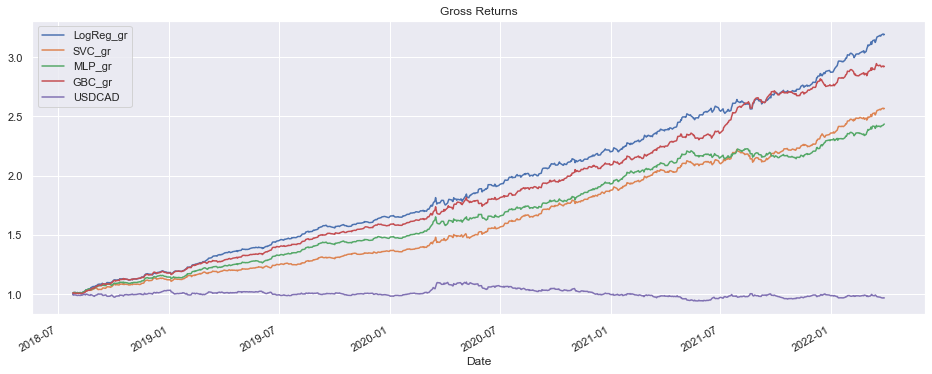

In [92]:
tc_perf = pd.DataFrame()
for i in test_data_dict.keys():
    tc_perf[f'{i}_gr'] = test_data_dict[i]['s']
    
tc_perf['USDCAD'] = test_data_dict[i]['USDCAD']
tc_perf.cumsum().apply(np.exp).plot(figsize=(16,6),title='Gross Returns');

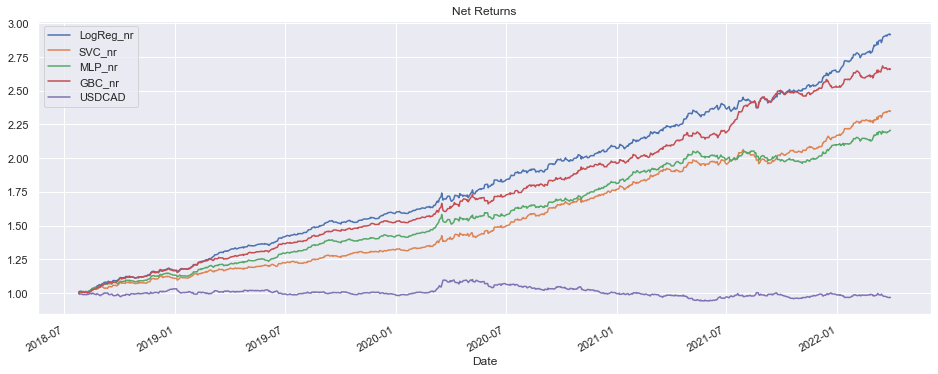

In [93]:
tc_perf = pd.DataFrame()
for i in test_data_dict.keys():
    tc_perf[f'{i}_nr'] = test_data_dict[i]['net_return']
    
tc_perf['USDCAD'] = test_data_dict[i]['USDCAD']
tc_perf.cumsum().apply(np.exp).plot(figsize=(16,6),title='Net Returns');

## <font color='blue'> __Conclusions__ </font>


In this study, we have highlighted the use of `scikit-learn` `Pipelines` and `GridSearchCV` to streamline the paramater tuning process.  In doing so we have showed that a few lines of code can replace a lengthy and costly nested `for loop`.  

We applied this framework to four models in the classification of USDCAD daily directional movements.  Each one of the four models significantly outperformed the passive buy-and-hold benchmark on both a gross and net return basis.  Not only was it important to select the correct features but also we believe that transforming the variables to produce stationary series was a contributing factor.

## <font color='blue'> __Extensions__ </font>


 1. Investigating whether the model is portable and produces similar outperformance with other currency pairs.
 2. Adjusting the model so that it could be applied intra-day for event-based backtesting and inspecting whether similar outperformance would be realized.
 3. Researching whether adding or removing features could improve performance and reduce complexity and cost.